# LLM Timeseries Forecasting for Physical Systems Example 1: Damped Harmonic Oscillator

LLMs have been shown to be [zero-shot timeseries forecasters](https://arxiv.org/pdf/2310.07820.pdf). I show their zero-shot timeseries forecasting ability can be augmented through contextual information about the generating process (in this case, a physical description about the dynamics of the underlying generating process), revealing a deep structural connection between next numeric token prediction and textual pretraining.  

In this notebook, I leverage the tokenization scheme described by [Gruver et al.](https://arxiv.org/pdf/2310.07820.pdf) to forecast future values for a damped harmonic oscillator system.

As an outline, the process is as follows:

- Generate data for damped harmonic oscillator system in range [-1,1], map and quantize position data to integers range [0,999] (this is handled in the ```./utils/dataGenerator.py``` directory, and a proof-of-concept of the tokenization scheme is demonstrated in ```./tokenizerDemo/tokenizerTest.py```)

- Feed the system prompt, as well as integer quantized positions into the prompt of GPT-3.5-Turbo, and have it predict the next twenty tokens. Each prompt is a separate GPT call, generating 100 independent generations of 20 integer tokens for each prompt. In the demo, this number is capped to 100 due to OpenAI API restrictions on concurrent requests (128 maximum), but in the full-scale study, I regenerate the data 10 times each and cache the result in ```./savedData``` files (whose names correspond to different prompts and physical forecasting tasks), for a total of n=1000 sequences of 20 tokens for each prompt. For the sake of the demo, the amount of generated sequences is set to 25 in order to not nuke my API key costs.
    - Prompts corresponding to ```./savedData``` filenames: 
        - ```UHONoInfo.csv```: Underdamped Harmonic Oscillator (Example 1) No Info Prompt, "You are a helpful assistant that performs time series predictions. "
        - ```UHO.csv```: Underdamped Harmonic Oscillator (Example 1) Physical Info Prompt, "You are a helpful assistant that performs time series predictions on an underdamped Damped Harmonic Oscillator. "
        - ```NoInfoSineWave.csv```: Sine wave (Example 2) without physical descriptor or phase descriptor, "You are a helpful assistant that performs time series predictions."
        - ```sineWave.csv```: Sine wave (Example 2) with physical descriptor, "You are a helpful assistant that performs time series predictions on a sinusoidal signal. Generated values must progressively increase to start." 
        - ```sineWavePhaseDescription.csv```: (Example 2) with physical descriptor and phase descriptor, "You are a helpful assistant that performs time series predictions on a sinusoidal signal. "
        - ```phaseDescriptionOnly.csv```: (Example 2) with phase descriptor only, "You are a helpful assistant that performs time series predictions. Generated values must progressively increase to start."

- After data is generated, a variety of metrics are generated (described in more detail in the "Data Analysis" section), including MAE, MSE, and fraction of sequences within various bounds. Results may be observed within this notebook or that of the ```README.md```

In [42]:
from dataGenerationUtils.dataGenerator import dataGenerator
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
import os

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Author: Peter Bowman-Davis, Nov 20, 2023                          #
# Timeseries Prediction for Physical Systems Demo                   #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Provide your OpenAI API key here
client = OpenAI(api_key='')


# Data Generation

Data is generated using the function exp(-x)*sin(2*pi*x), rescaled, integer-quantized, and turned into a string sequence that is ingestible by GPT.

In [52]:
# Define functions to be used
damped_harmonic_oscillator=lambda x: np.exp(-x)*np.sin(2*np.pi*x)
sine_wave=lambda x: np.sin(2*np.pi*x)

# Generate input sequence
dg=dataGenerator(t_max=3.33, samples=51, noise=0.0, fxn=damped_harmonic_oscillator)
inputSequence=dg.generateStringOutput()

num_train=31

train=inputSequence.split(" ")[0:num_train]
test=inputSequence.split(" ")[num_train:]



### Train / Test Split

"Train" means the in-context tokens that will be fed to the LLM in the prompt. "Test" will be used to evaluate MAE in the data analysis stage, e.g. used as the ground truth for evaluation.

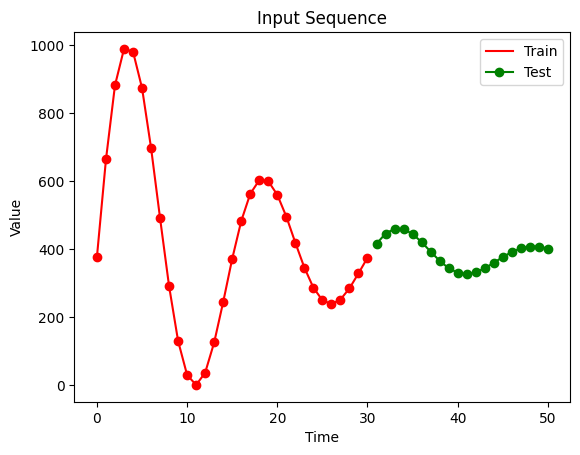

In [53]:
plt.plot(range(0,num_train),[int(y) for y in train], 'r',label="Train")
plt.plot(range(0,num_train),[int(y) for y in train], 'ro')
plt.plot(range(num_train,num_train+len(test)),[int(y) for y in test], 'go-',label="Test")
plt.title("Input Sequence")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

# GPT Call, Prompts, and Data Structure

For the purposes of this demo, I have turned n=25 to reduce API key costs, but in full-scale study below you can observe results of up to 1000 samples for all prompts.

In [57]:
def genNextSequence(inputSeq,sysPrompt):
    sysPrompt=sysPrompt
    prompt=inputSeq

    completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": sysPrompt},
        {"role": "user", "content": prompt}
    ],
    max_tokens=50,
    n=100
    )
    return completion

Below, the data object for storing our generated sequences for each prompt. To add a new prompt, simply add a new key to each dictionary and re-run the notebook.

In [58]:
suffix="Please continue the following sequence without producing any additional text, just return the next twenty numbers."
sysPrompts = {
    "UHONoInfo": "You are a helpful assistant that performs time series predictions. " + suffix,
    "UHO": "You are a helpful assistant that performs time series predictions on an underdamped Damped Harmonic Oscillator. " + suffix,
}

# Key: Prompt, Value: List of Lists of generated samples
dataByPrompt = { 
    "NoInfo": [],
    "UHO": [],
}

### Driver Code

#### Generate Data

For each system prompt, we generate the sequences using the above GPT API call. Data is then processed and sanitized (e.g. deleting any entries that do not follow sequence length constraints, making sure the returned value is only an integer number sequence, etc.). Finally, data is saved in the data directory, appending to the data CSV if prompt has been used in the past.

In [59]:
for sysPrompt in sysPrompts.values():
    generatedSamples=[]
    i = 0
    for message in genNextSequence(inputSequence, sysPrompt).choices:
        try: # Can't win them all – nonstandard response format intrinsic to LLMs requires some data cleaning
            generatedSample = [int(stringNumber) for stringNumber in message.message.content.split(" ") if stringNumber != "" and stringNumber != " "]
            generatedSamples.append(generatedSample)
            i += 1  
        except:
            pass

    # List to store only valid sequences
    validGeneratedSamples = []  

    for generatedSample in generatedSamples:
    
        if len(generatedSample) == 20:
            validGeneratedSamples.append(generatedSample)

        # If sequence is longer than 20 eleements, truncate to the first 20 elements
        elif len(generatedSample) > 20:
            truncatedSample = generatedSample[:20] 
            validGeneratedSamples.append(truncatedSample)
    
    generatedSamples = validGeneratedSamples
    dataByPrompt[sysPrompt] = generatedSamples

    for key, value in sysPrompts.items():
        if value == sysPrompt:
            sysPromptKey = key
            break
    
    if os.path.exists("./savedData/"+sysPromptKey + '.csv'):
        with open("./savedData/"+sysPromptKey + '.csv', 'a') as f:
            np.savetxt(f, generatedSamples, delimiter=',', fmt='%d')
    else:
        with open("./savedData/"+sysPromptKey + '.csv', 'w') as f:
            np.savetxt(f, generatedSamples, delimiter=',', fmt='%d')
    


#### Plot the sequences we just generated

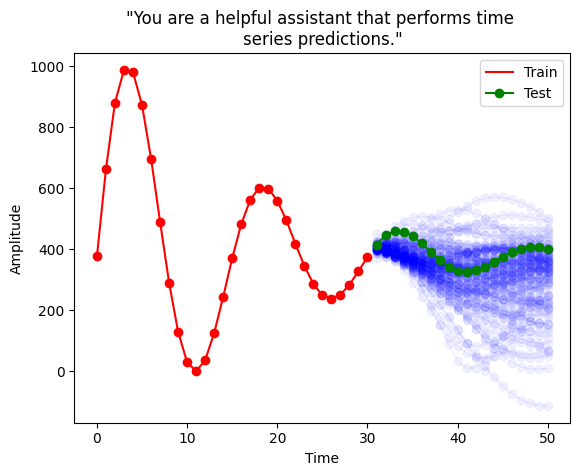

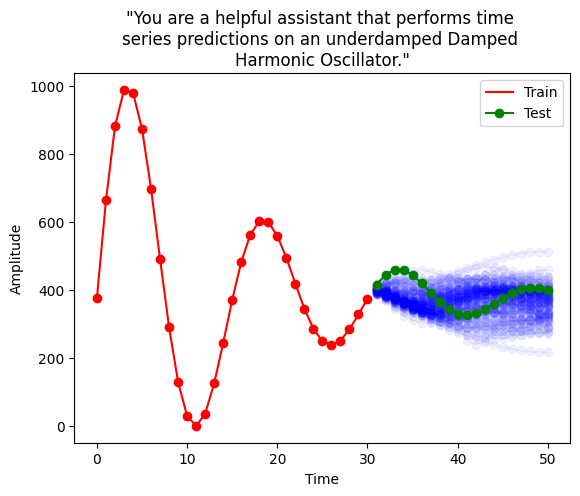

In [60]:
for sysPrompt in sysPrompts.values():
    plt.plot(range(0,len(train)),[int(y) for y in train], 'r',label="Train")
    plt.plot(range(0,len(train)),[int(y) for y in train], 'ro')
    for generatedSample in dataByPrompt[sysPrompt]: 
        plt.plot(range(len(train), len(train) + len(generatedSample)), generatedSample, 'bo-', alpha=0.05)
    plt.plot(range(num_train,num_train+len(test)),[int(y) for y in test], 'go-',label="Test")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

    
    displaytitle = sysPrompt[0:len(sysPrompt)-len(suffix)]
    
    # Format title to fit on plot
    if len(displaytitle) > 50:
        words = displaytitle.split()
        displaytitle = ""
        current_line = ""
        for word in words:
            if len(current_line) + len(word) <= 50:
                current_line += word + " "
            else:
                displaytitle += current_line + "\n"
                current_line = word + " "
        displaytitle += current_line
    displaytitle = displaytitle[0:len(displaytitle)-1]

    plt.title('"'+displaytitle+'"')
    plt.legend()
    plt.show()

#### As visible in the graphs, the prompt with physical information about the system (describing it as an underdamped harmonic oscillator) qualitatively exhibits lower spread in the generated data,and lower out of bounds generations (e.g. those that are physically unlikely, such as the predicted amplitude exceeding previous peaks or troughs). In the next section, we will try to quantify these qualities.

# Data Analysis

We will use a variety of metrics to assess the generated data versus the ground truth values to gague the general performance of each prompt.

1. MAE – Mean Absolute Error. Most general descriptor of error. 
2. MSE – Mean Square Error. More sensitive to outliers and will affect optimal sequence selection.
3. Range tests (e.g has any data x>=1000 || x< 0 which are outside of the single token scheme). In the following, a second boundary is used, which is the min and max of the train data (e.g. the true value). This second metric is therefore a measure of how much of the generated data has an amplitude less than that of the true data.

### MAE and MSE Calculation, Boundary Checking

In [61]:
bestSamples_MAE = {}
bestSamples_MSE = {}
bestSampleIndices_MAE = {}
bestSampleIndices_MSE = {}

for sysPrompt in sysPrompts.values():
    generatedSamples = dataByPrompt[sysPrompt]
    print(generatedSamples)
    processedGeneratedSamples = [x[0:len(test)] for x in generatedSamples if len(x) >= len(test)]
    testNums = [int(strNum) for strNum in test]

    # Calculate Mean Absolute Error and Mean Squared Error
    MAE = np.mean(np.abs(np.array(processedGeneratedSamples) - np.array(testNums)), axis=1)
    MSE = np.mean((np.array(processedGeneratedSamples) - np.array(testNums))**2, axis=1)

    # Store the best samples and their indices
    bestIndex_MAE = np.argmin(MAE)
    bestIndex_MSE = np.argmin(MSE)
    bestSamples_MAE[sysPrompt] = processedGeneratedSamples[bestIndex_MAE]
    bestSamples_MSE[sysPrompt] = processedGeneratedSamples[bestIndex_MSE]
    bestSampleIndices_MAE[sysPrompt] = bestIndex_MAE
    bestSampleIndices_MSE[sysPrompt] = bestIndex_MSE

    # Get the index of the best sample based on MAE
    bestSampleIndex_MAE = np.argmin(MAE)
    bestSample_MAE = processedGeneratedSamples[bestSampleIndex_MAE]

    # Get the index of the best sample based on MSE
    bestSampleIndex_MSE = np.argmin(MSE)
    bestSample_MSE = processedGeneratedSamples[bestSampleIndex_MSE]

    
    print(sysPrompt)
    print("Average MAE: ", np.mean(MAE))
    print("Average MSE: ", np.mean(MSE))
    print("Min MAE: ", MAE[bestSampleIndex_MAE])
    print("Min MSE: ", MSE[bestSampleIndex_MSE])

    def checkBounds(sample, upperBound=1000, lowerBound=0):
        for i in range(len(sample)):
            if sample[i] > upperBound or sample[i] < lowerBound:
                return True
        return False

    print("Fraction of samples with values outside of bounds: ", np.mean([checkBounds(sample) for sample in processedGeneratedSamples]))
    print("Fraction of samples with values outside of true bounds: ", np.mean([checkBounds(sample, upperBound=np.max([int(x) for x in test]), lowerBound=np.min([int(x) for x in test])) for sample in processedGeneratedSamples]))
    print("\n----------------------------------")

[[409, 409, 405, 398, 388, 376, 364, 352, 342, 334, 327, 321, 317, 315, 313, 313, 314, 316, 319, 322], [403, 395, 384, 372, 361, 353, 347, 342, 339, 338, 338, 339, 341, 344, 347, 350, 353, 355, 357, 359], [393, 375, 359, 346, 340, 340, 345, 353, 363, 374, 384, 393, 400, 404, 406, 406, 405, 402, 399, 396], [408, 400, 387, 370, 351, 333, 316, 302, 292, 287, 287, 291, 299, 308, 318, 327, 334, 339, 342, 342], [403, 396, 386, 375, 364, 352, 340, 329, 317, 307, 299, 292, 288, 286, 287, 291, 296, 302, 308, 312], [409, 405, 396, 382, 364, 342, 318, 293, 267, 242, 220, 201, 187, 179, 179, 185, 196, 212, 229, 245], [384, 378, 365, 346, 322, 293, 259, 221, 180, 137, 92, 46, 1, 49, 98, 148, 196, 242, 284, 322], [403, 396, 388, 380, 373, 366, 359, 353, 347, 341, 336, 331, 327, 322, 318, 314, 311, 307, 304, 301], [413, 416, 411, 398, 379, 358, 339, 326, 321, 325, 336, 351, 368, 383, 393, 396, 392, 383, 371, 357], [413, 424, 437, 449, 459, 466, 468, 467, 464, 460, 455, 451, 448, 446, 445, 446, 449, 4

#### The sequences with the additional physical information prompt appears to also have a lower average MAE and MSE, though the minimum MAE/MSE of each prompts appears to be much more close to each other than the averages. Furthermore, the out-of-bounds generation rate is significantly higher for the "no info prompt".

### Plotting of sequences with lowest MAE and MSE for each prompt

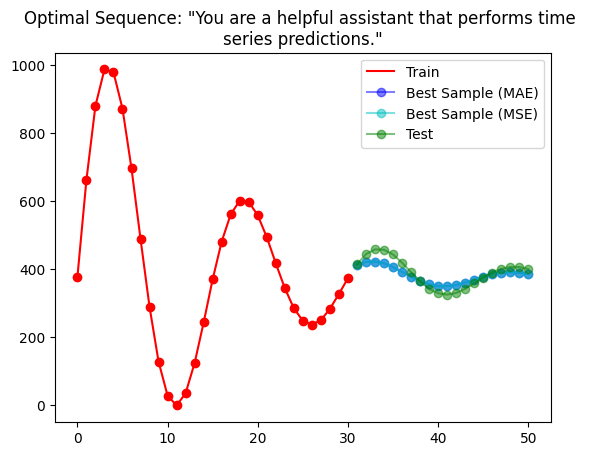

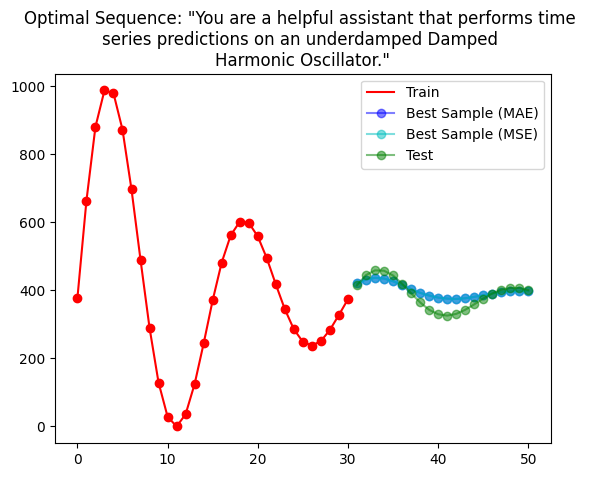

In [62]:
for sysPrompt in sysPrompts.values():
    
    # Plot training data
    plt.plot(range(0, len(train)), [int(y) for y in train], 'r', label="Train")
    plt.plot(range(0, len(train)), [int(y) for y in train], 'ro')

    # Plot the best MAE sample for the current prompt
    bestSample_MAE = bestSamples_MAE[sysPrompt]
    plt.plot(range(len(train), len(train) + len(bestSample_MAE)), bestSample_MAE, 'bo-', label="Best Sample (MAE)", alpha=0.5)

    # Plot the best MSE sample for the current prompt
    bestSample_MSE = bestSamples_MSE[sysPrompt]
    plt.plot(range(len(train), len(train) + len(bestSample_MSE)), bestSample_MSE, 'co-', label="Best Sample (MSE)", alpha=0.5)

    # Plot test data
    test_data_range = range(len(train), len(train) + len(testNums))
    plt.plot(test_data_range, testNums, 'go-', label="Test", alpha=0.5)

    displaytitle = sysPrompt[0:len(sysPrompt)-len(suffix)]
    
    # Format title to fit on plot
    if len(displaytitle) > 50:
        words = displaytitle.split()
        displaytitle = ""
        current_line = ""
        for word in words:
            if len(current_line) + len(word) <= 50:
                current_line += word + " "
            else:
                displaytitle += current_line + "\n"
                current_line = word + " "
        displaytitle += current_line
    displaytitle = displaytitle[0:len(displaytitle)-1]

    plt.title('Optimal Sequence: "'+displaytitle+'"')
    plt.legend()
    plt.show()


#### As indicated by the min MAE and MSE, the generated optimal sequences appear to have similar characteristics. However, that generated by the 'no info' prompt appears to have significantly more curvature than the 'physical info' prompt. This tracks with the result of the 'phyiscal info' prompt having a lower out of bounds rate and qualitatively lower variance (which we will measure in the next block) – the 'physical info' prompt appears to make the generated results closer to the mean value of the oscillator system (interestingly though, this is the case even when the mean does not equal zero due to the tokenization scheme making the oscillator bounds 0-999). 

# Full-Scale Study: Load Pre-Generated Data from ./savedData

#### For n=1000:

Largely the same analysis as above using existing data, with the addition of a measure of standard deviation and mean lines. 

Datafile:  UHONoInfo.csv
Average MAE:  77.82245000000002
Average MSE:  12778.02805
Min MAE:  16.65
Min MSE:  449.55
Fraction of samples with values outside of bounds:  0.029
Fraction of samples with values outside of true bounds:  0.666


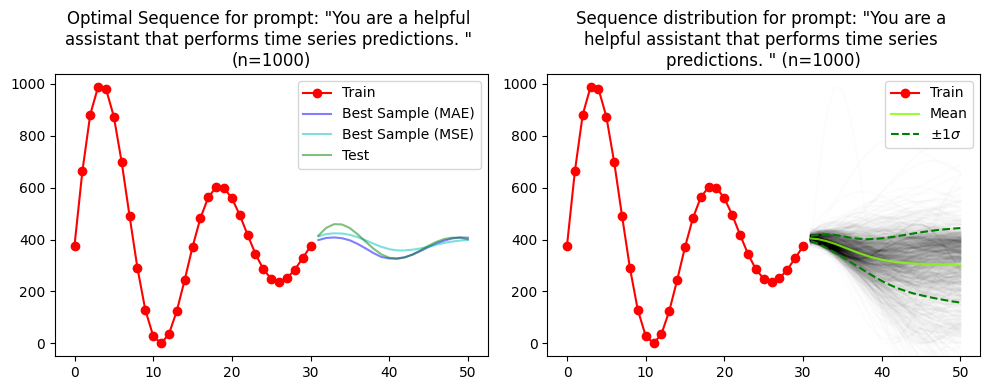

Datafile:  UHO.csv
Average MAE:  52.35185
Average MSE:  4960.373449999999
Min MAE:  17.85
Min MSE:  423.75
Fraction of samples with values outside of bounds:  0.002
Fraction of samples with values outside of true bounds:  0.349


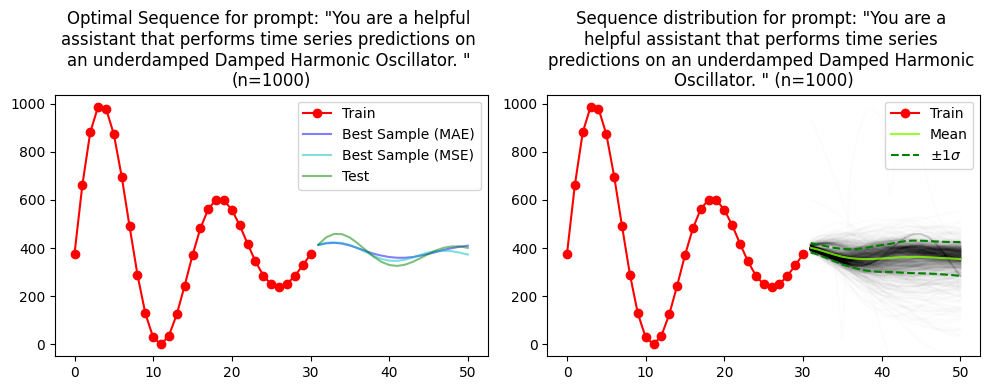

In [63]:

for datafile in ["UHONoInfo.csv","UHO.csv"]:
    sysPrompt=sysPrompts[datafile[0:len(datafile)-4]]
    data_list = []
    with open("./savedData/"+datafile, 'r') as file:
        for line in file:
            int_list = [int(number) for number in line.strip().split(',') if number != "" and number != " "]
            data_list.append(int_list)
    data_list=data_list[0:1000]
    generatedSamples = data_list
    processedGeneratedSamples = [x[0:len(test)] for x in generatedSamples if len(x) >= len(test)]  # Truncate or discard samples based on 'test' length
    testNums = [int(strNum) for strNum in test]

    # Calculate Mean Absolute Error
    MAE = np.mean(np.abs(np.array(processedGeneratedSamples) - np.array(testNums)), axis=1)
    # Calculate Mean Squared Error
    MSE = np.mean((np.array(processedGeneratedSamples) - np.array(testNums))**2, axis=1)

    def checkBounds(sample, upperBound=1000, lowerBound=0):
        for i in range(len(sample)):
            if sample[i] > upperBound or sample[i] < lowerBound:
                return True
        return False
    
    # Get the index of the best sample based on MAE and MSE
    bestSampleIndex_MAE = np.argmin(MAE)
    bestSample_MAE = processedGeneratedSamples[bestSampleIndex_MAE]
    bestSampleIndex_MSE = np.argmin(MSE)
    bestSample_MSE = processedGeneratedSamples[bestSampleIndex_MSE]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    means = np.mean(processedGeneratedSamples, axis=0)
    std_devs = np.std(processedGeneratedSamples, axis=0)

    # First subplot with individual best cases
    ax1.plot(range(0, len(train)), [int(y) for y in train], 'ro-', label="Train")
    ax1.plot(range(len(train), len(train) + len(bestSample_MAE)), bestSample_MAE, 'b', label="Best Sample (MAE)", alpha=0.5)
    ax1.plot(range(len(train), len(train) + len(bestSample_MSE)), bestSample_MSE, 'c', label="Best Sample (MSE)", alpha=0.5)
    test_data_range = range(len(train), len(train) + len(testNums))
    ax1.plot(test_data_range, testNums, 'g', label="Test", alpha=0.5)
    ax1.set_title('Optimal Sequence (n=' + str(len(processedGeneratedSamples))+')')

    displaytitle = 'Optimal Sequence for prompt: "'+sysPrompt[0:len(sysPrompt)-len(suffix)]+'" (n=' + str(len(processedGeneratedSamples))+')'
    
    # Format title to fit on plot
    if len(displaytitle) > 50:
        words = displaytitle.split()
        displaytitle = ""
        current_line = ""
        for word in words:
            if len(current_line) + len(word) <= 50:
                current_line += word + " "
            else:
                displaytitle += current_line + "\n"
                current_line = word + " "
        displaytitle += current_line
    displaytitle = displaytitle[0:len(displaytitle)-1]


    ax1.set_title(displaytitle)
    ax1.legend()
    ylim_ax1 = ax1.get_ylim()

    # Plot all sequences
    for sample in processedGeneratedSamples:
        ax2.plot(range(len(train), len(train) + len(sample)), sample, 'k', alpha=0.01)

    # Plot training data
    ax2.plot(range(0, len(train)), [int(y) for y in train], 'ro-', label="Train")

    # Plot mean of all sequences
    ax2.plot(range(len(train), len(train) + len(means)), means, 'chartreuse', label="Mean", alpha=0.8)
    ax2.plot(range(len(train), len(train) + len(means)), means + std_devs, 'g--', label=r"$\pm 1 \sigma$")
    ax2.plot(range(len(train), len(train) + len(means)), means - std_devs, 'g--')
    
    displaytitle='Sequence distribution for prompt: "'+sysPrompt[0:len(sysPrompt)-len(suffix)]+'" (n=' + str(len(processedGeneratedSamples))+')'
    
    # Format title to fit on plot
    if len(displaytitle) > 50:
        words = displaytitle.split()
        displaytitle = ""
        current_line = ""
        for word in words:
            if len(current_line) + len(word) <= 50:
                current_line += word + " "
            else:
                displaytitle += current_line + "\n"
                current_line = word + " "
        displaytitle += current_line
    displaytitle = displaytitle[0:len(displaytitle)-1]

    ax2.set_title(displaytitle)
    ax2.set_ylim(ylim_ax1)
    ax2.legend(loc='upper right')
    
    plt.tight_layout()


    print("Datafile: ", datafile)
    print("Average MAE: ", np.mean(MAE))
    print("Average MSE: ", np.mean(MSE))

    print("Min MAE: ", MAE[bestSampleIndex_MAE])
    print("Min MSE: ", MSE[bestSampleIndex_MSE])
    print("Fraction of samples with values outside of bounds: ", np.mean([checkBounds(sample) for sample in processedGeneratedSamples]))
    print("Fraction of samples with values outside of true bounds: ", np.mean([checkBounds(sample, upperBound=np.max([int(x) for x in test]), lowerBound=np.min([int(x) for x in test])) for sample in processedGeneratedSamples]))

    
    plt.show()

#### As predicted, the standard deviation bands (dark green dashed) for the generated sequences using the 'physical info' prompt are significantly tighter than those of the 'no info' prompt. Further, the 'no info' prompt seems to qualitatively exhibit a degree of heteroskedasticity (changing variance) over the generated sequence position, whereas the 'physical info' prompt seems to have a standard deviation that appears relatively across the generated sequence position. This could be an avenue of further research into statistical measurements of various prompts for timeseries forecasting.

# Conclusion / Analysis: 

Analyzing the effect of the addition of physical information into the prompt for the damped harmonic oscillator system (namely, the addition of the text "underdamped harmonic oscillator" into the prompt) both significantly reduces the variance of the generated data, and reduces the MAE and MSE by a large degree. Furthermore, the inclusion of this information radically decreases the amount of samples that are out of tokenization bounds (e.g. those sequences which contain any number above 1000 or below 0), and also increases the amount of sequences that are found within the bounds of the true value of the function (as reflected by the +/- sigma measures in the right graphs). Within a sample size of n=1000, the relative ergodicity of each generative process leads the minimum MAE and MSE to be very close to one another, and the optimal sequences for each prompt has similar geometric properties (e.g. resembles a sinusoid with a similar phase to that of the true value). 

This demonstrates strong empirical evidence for the possible benefit of incorporating physical descriptors into the zero-shot forecasting prompt. In turn, this reveals a nontrivial insight into transformers: zero-shot timeseries forecasting ability can be augmented through textual descriptors about the generating process, revealing a deep structural connection between next numeric token prediction and textual pretraining. That is to say, the LLM appears to be capable of effectively integrating contextual information about processes which generate timeseries data into next-token prediction, even when the contextual information pertains to abstract concepts such as an "underdamped harmonic oscillator". Even more impressive is that this entire process takes place in-context and without the use of techniques such as [Chain-of-Thought (Wei et al.)](https://arxiv.org/abs/2201.11903), which would likely be able to even further boost performance through a textual description generation process.

However, this techinque is not categorically effective: Example 2 (```sineWave.ipynb```) demonstrates that not all physical descriptors are equal: some physical descriptors may decrease MAE/MSE, whereas others seem to increase MAE/MSE or other statistical properties, such as the standard deviation bounds of responses. Thus, this investigation begs the questions of "what physical information is *most* effectively utilized in the timeseries forecasting process in a general sense?" and "what physical information maps to different statistical outcomes in the context of timeseries forecastnig for physical systems?", both worthy topic for future investigation. 